# Spectroscopic Eigensolver Algorithm with Sampler

This tutorial demonstrates the ability to send flexible circuits to the `Sampler` primitive by performing a simple example of the Spectroscopic Eigensolver Algorithm (SEA) ([arXiv:2202.12910](http://arxiv.org/abs/2202.12910)). The SEA is used for quantum simulation of model Hamiltonians, and works by interacting a "probe" auxiliary qubit with a simulation register. The energy of the probe qubit is swept and eigenvalues of the simulation Hamiltonian are observed as peaks or dips in the response, akin to the experimental tool of spectroscopy. Because each point (energy) is a different quantum circuit, this technique is expensive with respect to the number of circuits required. The `Sampler` provides the flexibility to send just a single circuit with the needed `Parameter`s passed.

## Set up your local development environment

This tutorial requires a Qiskit Runtime service instance. If you haven’t done so already, follow [these steps](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

In [1]:
# load necessary Runtime libraries
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

backend = "ibmq_qasm_simulator"  # use the simulator

## Simple Hamiltonian model

Let us consider a Pauli-X matrix acting on a qubit,
$$
H_{\rm Pauli}/\hbar = \mu X
$$
where we can set $\mu$ later, or even sweep its values as well. The SEA works by taking the model Pauli (qubit) Hamiltonian and building a larger "resonance" Hamiltonian that includes both the simulation register and probe qubit `q0` through
$$
H_{\rm res} / \hbar = -\frac{1}{2} \omega IZ + c XX + H_{\rm Pauli}/\hbar \otimes I
$$
where the angular frequency $\omega$ corresponds to the energy of the probe qubit, and $c$ is the coupling between the probe qubit and a qubit in the simulation register (`q1` in this case). The letters $I$, $X$, and $Z$ correspond to the Pauli spin matrices and their order reflect which qubit they operate on (note that this notation is little-endian). We will set $\hbar \equiv 1$ in the following code.

We can construct the SEA circuits with tools from Qiskit Opflow.

In [2]:
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Z

mu = Parameter("$\\mu$")
ham_pauli = mu * X

In [3]:
cc = Parameter("$c$")
ww = Parameter("$\\omega$")

ham_res = -(1 / 2) * ww * (I ^ Z) + cc * (X ^ X) + (ham_pauli ^ I)

Time evolve the resonance Hamiltonian.

In [4]:
tt = Parameter("$t$")
U_ham = (tt * ham_res).exp_i()

From the time-evolution operator $U_{\rm ham}$, we use the Suzuki-Trotter expansion to convert this operator into quantum circuits that implement discrete time steps of the simulation. The smaller the time steps (more Trotter steps), the more accurate the quantum circuit, but also longer depth, which could introduce errors when executing on noisy quantum hardware. We then transpile the circuits to IBM backend basis gates and measure only the probe qubit `q0`.

In [5]:
from qiskit import transpile
from qiskit.circuit import ClassicalRegister
from qiskit.opflow import PauliTrotterEvolution, Suzuki
import numpy as np

num_trot_steps = 5
total_time = 10
cr = ClassicalRegister(1, "c")

spec_op = PauliTrotterEvolution(
    trotter_mode=Suzuki(order=2, reps=num_trot_steps)
).convert(U_ham)
spec_circ = spec_op.to_circuit()
spec_circ_t = transpile(spec_circ, basis_gates=["sx", "rz", "cx"])
spec_circ_t.add_register(cr)
spec_circ_t.measure(0, cr[0])

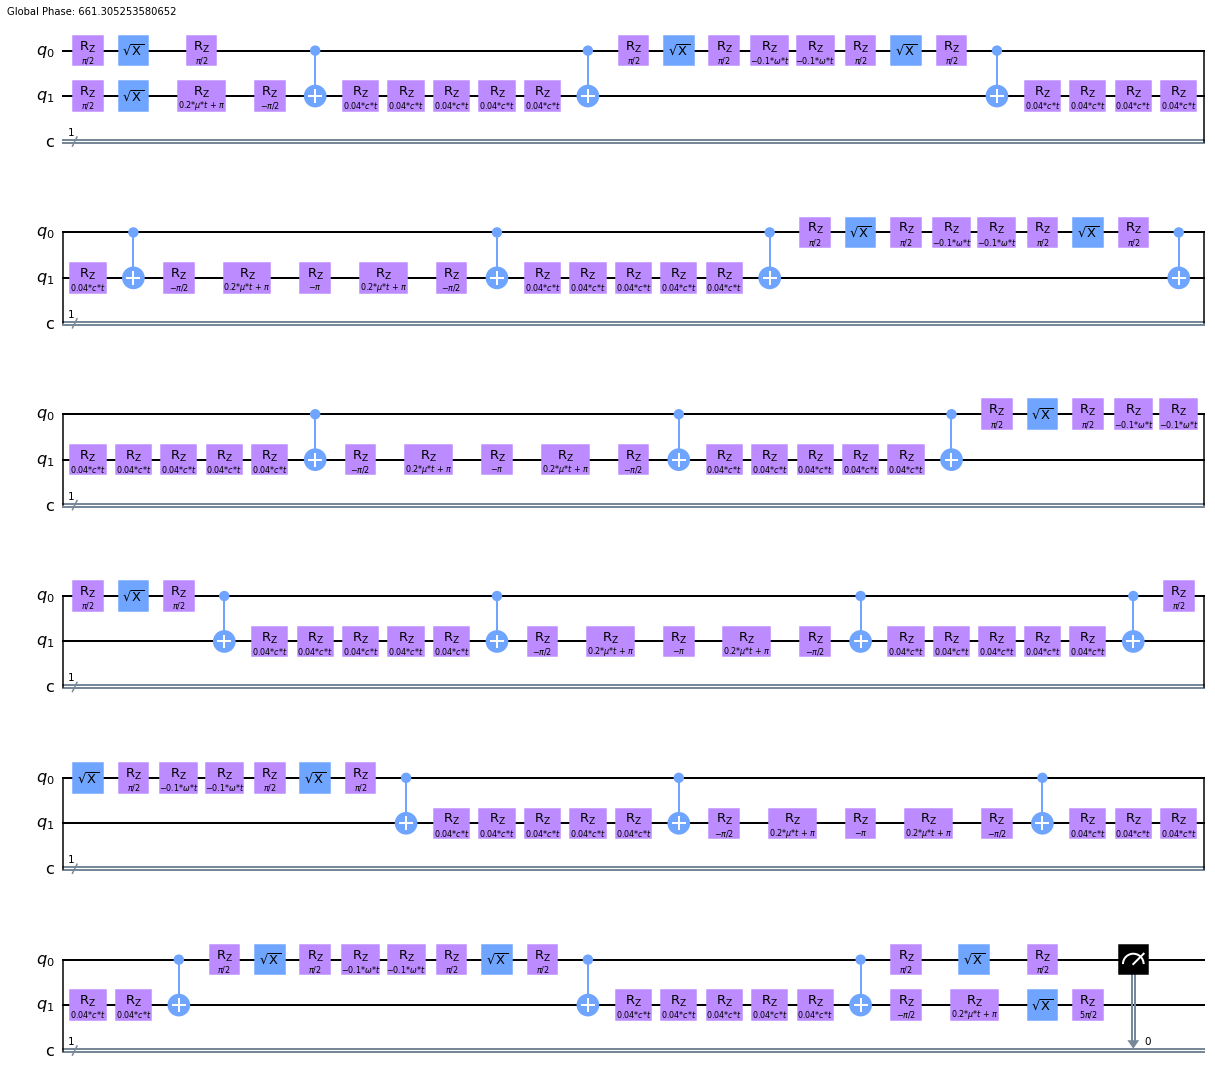

In [6]:
spec_circ_t.draw("mpl")

Now let's fix our parameters and sweep over the frequency with several points `num_pts`. The eigenvalues of our model Hamiltonian $H_{\rm Pauli}$ are $\pm \mu$, so we need to choose a range that includes those numbers.

Note that the `Parameter`s' keys and values must be separated and converted into a `List` of `List`s. The keys give us the `Parameter`s inside each circuit. In this case, we only have a single circuit, so the `List` of keys contains a single `List`. For the `Parameter` values, there is a `List` for each value of `ww`. 

In [7]:
# fixed Parameters
fixed_params = {cc: 0.3, mu: 0.7, tt: total_time}
# Parameter value for single circuit
param_keys = list(spec_circ_t.parameters)

# run through all the ww values to create a List of Lists of Parameter value
num_pts = 101
wvals = np.linspace(-2, 2, num_pts)
param_vals = []
for wval in wvals:
    all_params = {**fixed_params, **{ww: wval}}
    param_vals.append([all_params[key] for key in param_keys])

When calling the `sampler`, we specify a list of `circuits` pointing to the circuits desired to be run and the parameter values for each circuit.

In [8]:
with Session(backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=[spec_circ_t] * num_pts, parameter_values=param_vals, shots=1e5
    )
    result = job.result()

Build the $Z$ expectations by converting quasi-probabilities to $\langle Z \rangle$.

In [9]:
Zexps = []
for dist in result.quasi_dists:
    if 1 in dist:
        Zexps.append(1 - 2 * dist[1])
    else:
        Zexps.append(1)

As a quick check, we'll calculate the exact expectation values with Qiskit Opflow.

In [10]:
from qiskit.opflow import PauliExpectation, Zero

param_bind = {cc: 0.3, mu: 0.7, tt: total_time}

init_state = Zero ^ 2
obsv = I ^ Z
Zexp_exact = (U_ham @ init_state).adjoint() @ obsv @ (U_ham @ init_state)

diag_meas_op = PauliExpectation().convert(Zexp_exact)
Zexact_values = []
for w_set in wvals:
    param_bind[ww] = w_set
    Zexact_values.append(np.real(diag_meas_op.bind_parameters(param_bind).eval()))

And plotting everything together shows that the energy at which our peaks occurs to be $\pm \mu$.

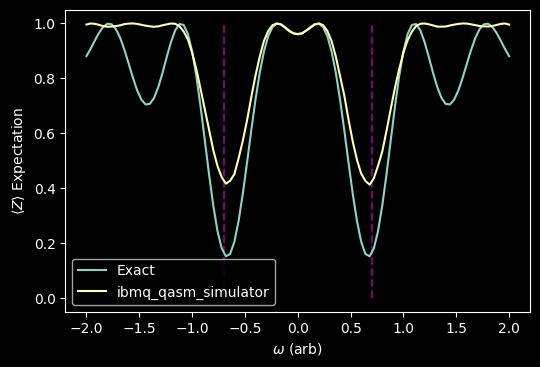

In [11]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

fig, ax = plt.subplots(dpi=100)
ax.plot([-param_bind[mu], -param_bind[mu]], [0, 1], ls="--", color="purple")
ax.plot([param_bind[mu], param_bind[mu]], [0, 1], ls="--", color="purple")
ax.plot(wvals, Zexact_values, label="Exact")
ax.plot(wvals, Zexps, label=f"{backend}")
ax.set_xlabel(r"$\omega$ (arb)")
ax.set_ylabel(r"$\langle Z \rangle$ Expectation")
ax.legend()

In [12]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.7.0'

In [13]:
from qiskit.tools.jupyter import *

%qiskit_version_table